# Reward decay functions

## Setup

In [1]:
import numpy as np
import math
from scipy.optimize import broyden1
import matplotlib.pyplot as plt
import warnings

## Types of decay
There are a couple of ways to implement a decaying reward function.

### Power function
The easiest implementation, given the current setup, would be to multiply the time to next reward by some constant each iteration:

$
t_n = \alpha t_{n-1} = \alpha^n t_0
$

where $n = 0, 1, 2, \ldots$ is the reward number. The updated code would look something like:

```
if (t > t_delay)
    ...
    if (PokeState == PostDispense)
        t_delay = t + delay
        delay = alpha * delay
...
if (PokeState == Poked) and (not Poked):
    ...
    delay = 1.0
```

The cumulative ($R(t)$) and instantaneous ($r(t)$) reward rates for this function are:

$
t_n = \alpha t_{n-1} = \alpha^n t_0 \quad \Rightarrow \quad n = \dfrac{ln(t) - ln(t_0)}{ln(\alpha)} \\
R(n) = n R_0 \quad \Rightarrow \quad R(t) = R_0 \dfrac{ln(t) - ln(t_0)}{ln(\alpha)} \\
r(t) = \dfrac{dR}{dt} = \left ( \dfrac{R_0}{ln(\alpha)} \right ) \left ( \dfrac{1}{t} \right )
$

where $R_0$ is the fixed volume for rewards.

### Exponential function
While any monotonically decreasing cumulative function can satisfy foraging theory, an exponential function is often justified. An exponentially decaying reward function has the following properties (using analogous terms to the power function):

$
r(t) = r_0 e^{-\frac{t}{\tau}} \\
R(t) = \int_0^t r(t')dt' = \int_0^t r_0 e^{-\frac{t'}{\tau}} dt' = r_0 \tau \left ( 1 - e^{-\frac{t}{\tau}} \right )
$

Working backwards to solve for $t$:

$
R^{-1} = t(R) = -\tau ln \left ( 1 - \dfrac{R}{r_0 \tau} \right ) \quad \Rightarrow \quad t_n = -\tau ln \left ( 1 - \dfrac{n R_0}{r_0 \tau} \right )
$

### Comparison between power and exponential decay
Let's first shift the power function so that $t_0 = 0$ to align it with the exponential function:

$
t_n = \alpha^n t'_0 - t'_0
$

where $t'_0$ now represents the new constant in the expression. Note that the cumulative and instantaneous reward functions will now include a $t + t'_0$ term where $t$ is above.

Let's look at the Taylor series expansions of the two equations for the inter-reward interval:

$
t_n = \alpha^n t'_0 - t'_0 
= e^{n ln(\alpha)} t'_0 
= t'_0 \sum_{m=0}^{\infty} \dfrac{\left ( n ln(\alpha) \right )^m}{m!}
= t'_0 \left ( 1 + n ln(\alpha) + \dfrac{\left ( n ln(\alpha) \right )^2}{2} + \ldots \right )
\quad \text{(power)} \\
t_n = -\tau ln \left ( 1 - \dfrac{n R_0}{r_0 \tau} \right ) 
= -\tau \left ( - \sum_{m=1}^{\infty} \dfrac{\left ( \frac{n R_0}{r_0 \tau} \right )^m}{m} \right )
= \tau \left ( \dfrac{n R_0}{r_0 \tau} + \dfrac{1}{2} \left ( \dfrac{n R_0}{r_0 \tau} \right )^2 + \ldots \right )
\quad \text{(exponential)}
$

Looking at the first-order approximation for each function, we arrive at the equation:

$
\tau \left ( \dfrac{n R_0}{r_0 \tau} \right ) = t'_0 \left ( 1 + n ln(\alpha) \right ) - t'_0 \\
\Rightarrow \dfrac{R_0}{r_0} = t'_0 ln(\alpha) \\
\Rightarrow \alpha = e^{\frac{R_0}{r_0 t'_0}}
$

and setting $t'_0$ such that $t_1$ are equal for both functions:

$
t_1 = \alpha t'_0 - t'_0 = -\tau ln \left ( 1 - \dfrac{R_0}{r_0 \tau} \right )
$

We want to approximate a power function with parameters $\{t'_0, \alpha\}$ for an exponential function with parameters $\{\tau, r_0, R_0\}$. Since we now have two equations and two unknowns, we can solve for $\{t'_0, \alpha\}$ by substituting for $\alpha$:

$
t'_0 \left ( \alpha - 1 \right ) = t'_0 \left ( e^{\frac{R_0}{r_0 t'_0}} - 1 \right ) = -\tau ln \left ( 1 - \dfrac{R_0}{r_0 \tau} \right ) \\
\Rightarrow t'_0 \left ( e^{\frac{R_0}{r_0 t'_0}} - 1 \right ) + \tau ln \left ( 1 - \dfrac{R_0}{r_0 \tau} \right ) = 0
$

and then plugging this value of $t'_0$ into $\alpha = e^{\frac{R_0}{r_0 t'_0}}$. This leads to a first-order approximation of the exponential function with a power function. Unfortunately, if we wish to obtain a better approximation by utilizing the second-order and higher terms, we lose the nice cancellation that occurred in the first equation of the system, leading to a dependence on $n$.

## Plot decay functions

In [4]:
def get_reward_times(method='integral', **kwargs):
    """
    Time of next reward based on exponentially decaying instantaneous reward rate.
    
    Args:
    - tau: decay parameter
    - r_0: initial instantaneous reward rate
    - R_0: fixed reward size
    - t_0: initial time in series function
    - alpha: base in series function
    - t: current time
    - n: reward number
    - method:
        - 'integral': integrate under decaying reward rate
        - 'series': multiply previous interval by constant
    
    Returns:
    - t_reward: time of next reward
    """
    
    if method.lower() == 'integral':
        return _get_reward_times_from_integral(**kwargs)
    elif method.lower() == 'series':
        return _get_reward_times_from_series(**kwargs)
    else:
        raise ValueError('Unknown method \'%s\'.' % method)
  
def _get_reward_times_from_integral(tau=1.0, r_0=1.0, R_0=1.0, t=None, n=None):
    if t is not None:
        t_reward = np.zeros(t.shape)
        idx = (t >= tau*np.log((tau*r_0)/R_0))
        t_reward[~idx] = -tau*np.log(np.exp(-t[~idx]/tau) - (R_0/(tau*r_0)))
    elif n is not None:
        t_reward = np.zeros(n.shape)
        idx = (n >= tau*r_0/R_0)
        t_reward[~idx] = -tau*np.log(1.0 - (n[~idx]*R_0)/(tau*r_0))
    else:
        raise ValueError('t or n must be provided.')
    
    if idx.any():
        t_reward[idx] = np.inf
        warnings.warn('Time(s) to next reward are infinite.')
    
    return t_reward

def _get_reward_times_from_series(alpha=1.0, t_0=1.0, t=None, n=None):
    if t is not None:
        return alpha*t
    elif n is not None:
        return t_0*alpha**n - t_0
    
def get_series_params(tau, r_0, R_0):
    # Solve equation for t_0
    F = lambda t_0: t_0*(np.exp(R_0/(r_0*t_0)) - 1.0) + tau*np.log(1.0 - R_0/(tau*r_0))
    t_0 = broyden1(F, np.array([1.0]))
    
    # Plug in to get alpha
    alpha = np.exp(R_0/(r_0*t_0))
    
    return t_0, alpha

integral: tau = 12.00, r_0 = 1.00, R_0 = 2.00
series:   t_0 = 11.30, alpha = 1.19


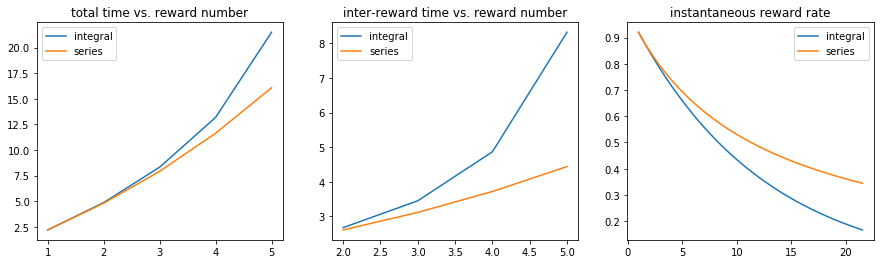

In [14]:
# Set parameters
tau = 12
r_0 = 1.0
R_0 = 2
t_0, alpha = get_series_params(tau, r_0, R_0)
 
# Set range
t = np.linspace(1, tau*np.log((tau*r_0)/R_0), 100)
n = np.arange(1, math.ceil(tau*r_0/R_0))

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

# Plot absolute reward times
ax[0].plot(n, get_reward_times(method='integral', tau=tau, r_0=r_0, R_0=R_0, n=n), label='integral')
ax[0].plot(n, get_reward_times(method='series', alpha=alpha, t_0=t_0, n=n), label='series')
ax[0].set_title('total time vs. reward number')
ax[0].legend()

# Plot differences in reward times
ax[1].plot(n[1:], np.diff(get_reward_times(method='integral', tau=tau, r_0=r_0, R_0=R_0, n=n)), label='integral')
ax[1].plot(n[1:], np.diff(get_reward_times(method='series', alpha=alpha, t_0=t_0, n=n)), label='series')
ax[1].set_title('inter-reward time vs. reward number')
ax[1].legend()

# Plot instantaneous reward rate
ax[2].plot(t, r_0*np.exp(-t/tau), label='integral')
ax[2].plot(t, (R_0/np.log(alpha)*(1.0/(t + t_0))), label='series')
ax[2].set_title('instantaneous reward rate')
ax[2].legend()

# Print parameters
print('integral: tau = %.2f, r_0 = %.2f, R_0 = %.2f' % (tau, r_0, R_0))
print('series:   t_0 = %.2f, alpha = %.2f' % (t_0, alpha))

Not a bad approximation for an automated approach. However, note that $\alpha$ is still a bit too small to capture fully the drop-off in the exponential function.